# OBSERVATION v. SIMULATION VALUES: A PYTHON TOOL FOR MODFLOW 6

_____________
This Jupyter Notebook is designed to guide you through the calibration of a Groundwater Flow Model. 

As the user, you will only need to ensure three things:
-   Respect the input observations format as provided.
-   Place all the output files from Modflow/ModelMuse ``<name_of_your_model>.ob.gw_out_head.csv`` in the same folder.
-   Specify the starting time of your model (**44105**, in this example)

This Jupyter Notebook will help you determine whether: \
**(i)** your calibration is satisfactory, \
**(ii)** you can identify the weakest points or areas of the model that require more attention for future recalibration, and \
**(iii)** whether these weak points need to drain more water (or less), or whether they require higher or lower hydraulic conductivity.
____________


## Load the needed libraries

In [1]:
#-- Check and install required packages if not already installed 
import sys
import subprocess

def if_require(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        
#-- Install packages only if they aren't already installed 
if_require("seaborn")
if_require("ipywidgets")
if_require("glob2")
if_require("geopy")
if_require("geopandas")
if_require("folium")
if_require("matplotlib")
if_require("mapclassify")

#-- Import the rest of libraries 
import os
import math
import glob
import base64
import folium
import traitlets
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from io import BytesIO
from functools import reduce
from ipywidgets import Layout, Output
from tkinter import Tk, filedialog
from shapely.geometry import Point 
from IPython.display import display
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output, HTML

## Load the input observations

In [2]:
class SelectFileButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFileButton, self).__init__()      
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)
          
        # Initialize observations attribute
        self.observations = []   
        # Initialize coordinates attribute
        self.coordinates = [] 
         
    def select_files(self, b):
        """Generate instance of tkinter.filedialog.
    
        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        with out:
            try:
                # Create Tk root
                root = Tk()
                # Hide the main window
                root.withdraw()
                # Raise the root to the top of all windows.
                root.call('wm', 'attributes', '.', '-topmost', True)
                # List of selected files will be set to b.value
                selected_files = filedialog.askopenfilename(multiple=True)
                if selected_files:
                    b.files = selected_files
                    b.description = "Files Selected"
                    b.icon = "check-square-o"
                    b.style.button_color = "lightgreen"
                    file_name, file_extension = os.path.splitext(b.files[0])
                    if file_extension != '.xlsx' and file_extension != '.csv':
                        print("Your selected file is neither a CSV nor an XLSX file. Please select a correct input file.")
                    else:
                        print(f"You selected {os.path.basename(b.files[0])} file as your input observation data.")              
                        # We get the first row as a header and skip the next two rows, since they are the coordinates
                        b.observations.append(pd.read_excel(selected_files[0], skiprows=range(1, 3)))                   
                        # We get the coordinates rows
                        # 1) Extract values with '_obs' and remove the '_obs' suffix to get the actual names                     
                        coordinates = (pd.read_excel(selected_files[0]).loc[:1])
                        nameObs = [item.replace('_obs', '') for item in list(coordinates.columns) if '_obs' in item]
                        # 2) Extract the values of X and Y coordinates
                        lat = coordinates.iloc[0,1::2].values
                        long = coordinates.iloc[1,1::2].values
                        # Create a list of Point objects
                        points = [Point(float(x), float(y)) for x, y in zip(lat, long)]
                        # 3) We merge all this in one single DataFrame called "coordinates"
                        b.coordinates.append({"Name": nameObs, "Geometry": points})   
                else:
                    print("No file selected.")
            except:
                pass
        
        def get_input_file(self): 
            """Returns the selected file."""
            return self.observations

out = widgets.Output()
input_file = SelectFileButton()
widgets.VBox([input_file, out])

## Load the output simulated values

In [3]:
class SelectDirectoryButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectDirectoryButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Model Output Directory"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_directory)
        # Set the width of the widget
        self.layout.width = '300px'
        # Initialize selected_file attribute to None
        self.selected_file = None
        # Initialize sim attribute to None
        self.output_file = []    
        # Initialize dropdown widget
        self.dropdown = None
        # Initialize confirm button
        self.confirm_button = None

    def select_directory(self, b):
        """Generate instance of tkinter.filedialog.
    
        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        with out:
            try:
                # Create Tk root
                root = Tk()
                # Hide the main window
                root.withdraw()
                # Raise the root to the top of all windows.
                root.call('wm', 'attributes', '.', '-topmost', True)
                # List of selected files will be set to b.value
                selected_directory = filedialog.askdirectory()
                # point to the selected directory
                os.chdir(selected_directory)
                # Use glob.glob() to find files matching the pattern "*ob_gw_out_head.csv"
                file_paths = glob.glob('*.ob_gw_out_head.csv')            
                # Count how many observations files there are in the output model folder
                nfiles = len(file_paths)
                # The list of file_paths is converted into tuple
                file_paths = tuple(file_paths)              
                # If there is no output file in selected folder, print out a warning
                if nfiles == 0:
                    print(f"No output observations files found in folder {selected_directory}")
                elif nfiles >= 1:
                    print(f"Found {nfiles} output observations files in Model Output Folder. Select one, or more than one to compare among simulations.\n")
                    self.dropdown = self.dropdown_widget(description='Choose the output file:', 
                                                     options=file_paths, style={'description_width': 'initial', 'width': '400px'})
                    self.dropdown.layout.width = '400px'
                    display(self.dropdown)
                    self.confirm_button = widgets.Button(description="Confirm Selection", style={"button_color": "orange"})
                    self.confirm_button.on_click(self.confirm_selection)
                    display(self.confirm_button)
            except Exception as e:
                print("An error occurred:", e)
    
    def confirm_selection(self, b):
        """Confirm the selection of the file."""
        with out:
            try:
                if self.dropdown:
                    selected_value = self.dropdown.value
                    if selected_value:
                        self.selected_file = selected_value
                        self.description = "Files Selected"
                        self.icon = "check-square-o"
                        self.style.button_color = "lightgreen"
                        simulation_outputs = list(output_dir.selected_file)
                        nsim = len(simulation_outputs)
                        if nsim > 1:
                            for x in range(nsim):
                                self.output_file.append(pd.read_csv(simulation_outputs[x], sep=","))
                        else:
                            self.output_file.append(pd.read_csv(simulation_outputs[0], sep=","))
            except Exception as e:
                print("An error occurred:", e)                

    def dropdown_widget(self, description: str, options: list, style: str):
        """
        Function for the generation of the dropdown widget.
        
        Parameters:
            - description (str): description of the widget
            - options (list): the values to choose in the widget
            - value (str): the value to initialize the widget
        Return:
            - widget_value: returns the value of the widget
        """ 
        return widgets.SelectMultiple(description=description, options=options, style=style)
    
    def get_selected_file(self):
        """Returns the selected file."""
        return self.selected_file, self.output_file
            
out = widgets.Output()
output_dir = SelectDirectoryButton()
widgets.VBox([output_dir, out])


## Defining the starting time

**NOTE**: Remember, in this case *we know* it should be **44105**

In [4]:
# Create a text input widget for starting time with no initial value
st_time_wid = widgets.Text(value='', description='Starting Time:', 
                        style={'description_width': 'initial'})

# Set a fixed width for the widget descriptions
st_time_wid.layout.width = '500px'

# Define the variable to store starting time
st_time = None  # Use None as a placeholder for an undefined value

# Function to update starting time variable when the input changes
def update_st_time(change):
    global st_time
    new_value = change.new.strip()  # Remove leading and trailing whitespaces
    if new_value == '':
        st_time = None  # Set to None if the input is empty
    else:
        try:
            st_time = int(new_value)
        except ValueError:
            print("Invalid input. Please enter a valid integer.")

# Attach the function to the input widget's value change event for starting time
st_time_wid.observe(update_st_time, names='value')

# Create a button widget
button = widgets.Button(description="Confirm Starting Time")

def on_button_click(b):
    global st_time

    # Output the starting time
    print(st_time)

# Attach the function to the button's click event
button.on_click(on_button_click)

# Display the widgets on two separate lines
display(widgets.VBox([st_time_wid, button]))

## Real observation values vs Simulated ones

### All model results in a single plot

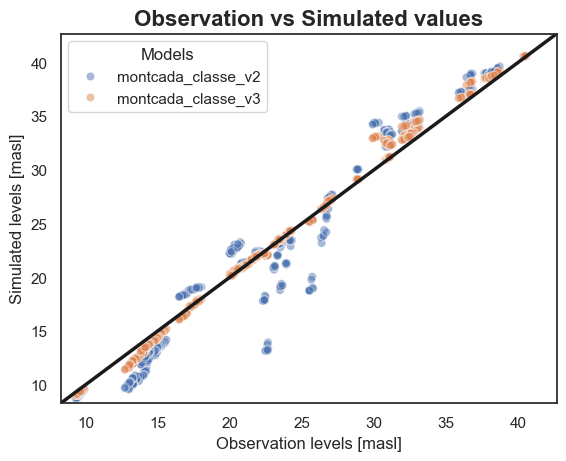

In [5]:
names = output_dir.selected_file
model_names = [names.split(".ob_gw_out_head.csv")[0] for names in output_dir.selected_file]

sim = []
allModelSimulations = []
nsim = len(output_dir.output_file)
for simulation in range(nsim):
    sim.append(output_dir.output_file[simulation])
    nameObs = sim[simulation].columns[1:].tolist()
    nobs = len(nameObs)
    tsim = int(st_time) + sim[simulation].iloc[:,0] - 1
    dh = np.zeros((len(tsim)-1, len(tsim)-1))
    hsim = np.zeros((len(tsim), nobs))
    for i in range(nobs):
        col = sim[simulation].columns.get_loc(nameObs[i])
        if col > 0:
            hsim[:,i] = sim[simulation].iloc[:,col]
    allModelSimulations.append(hsim)
    
# Extract observation names
observationNames = [name.replace('HD_', '') for name in nameObs]
input_file.coordinates = [dictionary for dictionary in input_file.coordinates if not any(key.startswith('RMSE') for key in dictionary.keys())]

# Building a dictionary with the coordinates and the RMSE for each observation for each model 
try: 
    ########################################################################################################################
    keys = model_names
    obs_to_plot = {key: [] for key in model_names}
    sim_to_plot = {key: [] for key in model_names}
    ########################################################################################################################
    
    # for model in range(len(allModelSimulations)):   
    for model in range(len(keys)):    
        valuesRMSE = list() 
                
        for observation in range(len(observationNames)):
            # simulation
            simulation_time = np.arange(st_time, st_time + len(allModelSimulations[model]))
            simulation_value = allModelSimulations[model][:, observation]
            simulation_matrix = np.column_stack((simulation_time, simulation_value))
            
            # observations
            observation_time = input_file.observations[0][f'{observationNames[observation]}_time']
            observation_time = observation_time[~np.isnan(observation_time)]
            observation_value = input_file.observations[0][f'{observationNames[observation]}_obs']
            observation_value = observation_value[~np.isnan(observation_value)]
            
            x = 0
            for time in observation_time:
                if time < st_time:
                    observation_time = observation_time.drop(x)
                    observation_value = observation_value.drop(x)
                x =+ 1
                
            condition = observation_time <= simulation_time[-1]
            observation_time = observation_time[condition]
            observation_value = observation_value[condition]

            if len(np.unique(observation_time)) < len(observation_time):
                x = 0
                for time in observation_time[1:]:
                    if time == observation_time[x]:
                        observation_value[x] = np.mean([observation_value[x], observation_value[x-1]])
                        observation_value_filtered = observation_value.drop(x)
                        observation_time_filtered = observation_time.drop(x)
                    x += 1
                simulation_common_values = simulation_matrix[np.isin(simulation_matrix[:, 0], observation_time_filtered)]
                
                ########################################################################################################################              
                obs_to_plot[model_names[model]].append(observation_value_filtered.to_numpy()) 
                sim_to_plot[model_names[model]].append(simulation_common_values[:, 1])
                ########################################################################################################################
                
                # Calculate root mean squared error (RMSE)
                MSE = mean_squared_error(observation_value_filtered, simulation_common_values[:,1])
                RMSE = math.sqrt(MSE)
            else:
                simulation_common_values = simulation_matrix[np.isin(simulation_matrix[:, 0], observation_time)]
                
                ########################################################################################################################
                obs_to_plot[model_names[model]].append(observation_value.to_numpy()) 
                sim_to_plot[model_names[model]].append(simulation_common_values[:, 1])
                ########################################################################################################################
                                
                # Calculate mean squared error (MSE)
                MSE = mean_squared_error(observation_value, simulation_common_values[:,1])
                RMSE = math.sqrt(MSE)       
            valuesRMSE.append(RMSE)      
        input_file.coordinates[0].update({f'RMSE model {model_names[model]}': valuesRMSE})
except ValueError as ve:
        print(f"Check the {observationNames[observation]} input values. Perhaps there are some repeated times? \n\n", ve)            
    
valuesRMSE = np.array([input_file.coordinates[0][f'RMSE model {model_names[model]}'] for model in range(len(allModelSimulations))])
valuesRMSE = valuesRMSE.flatten()

dfMap = pd.DataFrame.from_dict(input_file.coordinates[0])


key = model_names
obs_to_plot_2 = {key: [] for key in model_names}
sim_to_plot_2 = {key: [] for key in model_names}
for key in obs_to_plot:
    obs_to_plot_2[key] = np.concatenate(obs_to_plot[key])
    sim_to_plot_2[key] = np.concatenate(sim_to_plot[key])
    
def limits_plot(obs_to_plot_2, sim_to_plot_2):
     
    min_obs = []
    max_obs = []
    for key in obs_to_plot_2:
        min_obs.append(min(obs_to_plot_2[key]))
        max_obs.append(max(obs_to_plot_2[key]))
    min_sim = []
    max_sim = []
    for key in obs_to_plot_2:
        min_sim.append(min(sim_to_plot_2[key]))
        max_sim.append(max(sim_to_plot_2[key]))
    
    min_plot = min(
        [min(min_obs),
        min(min_sim)]
    )   
    max_plot = max(
        [max(max_obs),
        max(max_sim)]
    )
    
    x = [min_plot-(min_plot*0.05), max_plot+(max_plot*0.05)]
    
    return x
   
concatenated_obs = []
for key in obs_to_plot_2:
    for value in range(len(obs_to_plot_2[key])):
        concatenated_obs.append(obs_to_plot_2[key][value])
        
concatenated_sim = []
for key in sim_to_plot_2:
    for value in range(len(sim_to_plot_2[key])):
        concatenated_sim.append(sim_to_plot_2[key][value])

concatenated_mod = []
concatenated_size = []
for model in model_names: 
    for ln in range(len(obs_to_plot_2[model])):
        concatenated_mod.append(model)
        concatenated_size.append(400)

data = {
    "Observations": concatenated_obs,
    "Simulated": concatenated_sim,
    "Models": concatenated_mod  
}

df = pd.DataFrame(data)

x = limits_plot(obs_to_plot_2, sim_to_plot_2)
        
# Set Seaborn theme
sns.set_theme(style="white")

# Plot 'Observations' against 'Simulated' with legend only for 'Models'
g = sns.scatterplot(x="Observations", y="Simulated", 
                    hue="Models", alpha=0.5, data=df, legend="brief")

# Overlay the line plot
plt.plot(x, x, linewidth=2.5, color='k', label='_nolegend_')  

# Customize axis labels
plt.xlabel('Observation levels [masl]')
plt.ylabel('Simulated levels [masl]')

# Set title with bigger font size and in bold
plt.title(f'Observation vs Simulated values', fontsize=16, fontweight='bold')

# Set x-axis and y-axis limits
plt.xlim(x[0], x[1])
plt.ylim(x[0], x[1])

# Display the plot
plt.show()

### Each model in a separate plot

In [6]:
key = model_names
obs_to_plot_2 = {key: [] for key in model_names}
sim_to_plot_2 = {key: [] for key in model_names}
for key in obs_to_plot:
    obs_to_plot_2[key] = np.concatenate(obs_to_plot[key])
    sim_to_plot_2[key] = np.concatenate(sim_to_plot[key])
    
def limits_plot(obs_to_plot_2, sim_to_plot_2):
     
    min_obs = []
    max_obs = []
    for key in obs_to_plot_2:
        min_obs.append(min(obs_to_plot_2[key]))
        max_obs.append(max(obs_to_plot_2[key]))
    
    min_sim = []
    max_sim = []
    for key in obs_to_plot_2:
        min_sim.append(min(sim_to_plot_2[key]))
        max_sim.append(max(sim_to_plot_2[key]))
    
    min_plot = min(
        [min(min_obs),
        min(min_sim)]
    )
    
    max_plot = max(
        [max(max_obs),
        max(max_sim)]
    )
    
    x = [min_plot-(min_plot*0.05), max_plot+(max_plot*0.05)]
    
    return x
   
def update_plot(selected_model):
      
    x = limits_plot(obs_to_plot_2, sim_to_plot_2)
        
    # Create a new DataFrame with the concatenated values
    concatenated_values = pd.DataFrame({'Observations': obs_to_plot_2[selected_model], 
                                        'Simulated': sim_to_plot_2[selected_model]})

    # Set Seaborn theme
    sns.set_theme(style="white")

    # Plot 'Observations' against 'Simulated' with other semantics   
    sns.relplot(x="Observations", y="Simulated", size=400,
                sizes=(100, 100), alpha=.2, palette="muted",
                height=6, data=concatenated_values, legend=False)

    # Overlay the line plot
    plt.plot(x, x, linewidth=2.5, color='k', label='_nolegend_')  

    # Customize axis labels
    plt.xlabel('Observation levels [masl]')
    plt.ylabel('Simulated levels [masl]')

    # Set title with bigger font size and in bold
    plt.title(f'Observation vs Simulated values', fontsize=16, fontweight='bold')

    # Set x-axis and y-axis limits
    plt.xlim(x[0], x[1])
    plt.ylim(x[0], x[1])

    plt.show()

sel_model = widgets.Dropdown(
    options=model_names,
    value=model_names[0],  # Default selection
    description='Select Model:',
    layout=Layout(width='30%', height='30px'),
    disabled=False
)

# Use interactive widget to update the map based on dropdown selection
interactive_plot = widgets.interactive_output(update_plot, {'selected_model': sel_model})

# Display the dropdown and the map
display(sel_model, interactive_plot)


Dropdown(description='Select Model:', layout=Layout(height='30px', width='30%'), options=('montcada_classe_v2'…

Output()

## Real observation values vs Simulated ones at each observation point

**Note**: You can download the results for a selected observation point

In [7]:
from sklearn.metrics import mean_absolute_error 

# Create a dropdown widget for choosing observation names
sel_observation = widgets.Dropdown(
    options=observationNames,
    description='Observation:',
    disabled=False
)

# Create a dropdown widget for saving the graph
sel_save = widgets.Dropdown(options=['NO', 'YES'], value="NO", description="Download")

# Define a function to reset the 'save' dropdown
def reset_save_dropdown(change):
    sel_save.value = "NO"

# Add event listeners to 'observations' dropdowns
sel_observation.observe(reset_save_dropdown, names='value')

# Function to update the plot based on the selected observation name
def update_plot(observation_name, save):
    try:
        fig = plt.figure(figsize=(12, 6)) 
        for model in range(len(allModelSimulations)):
            # Get the index of the selected observation name
            obs_index = nameObs.index(f'HD_{observation_name}')
            
            # simulation
            simulation_time = np.arange(st_time, st_time + len(allModelSimulations[model]))
            simulation_value = allModelSimulations[model][:, obs_index]
            simulation_matrix = np.column_stack((simulation_time, simulation_value))
      
            # observations
            observation_time = input_file.observations[0][f'{observation_name}_time']
            observation_time = observation_time[~np.isnan(observation_time)]
            observation_value = input_file.observations[0][f'{observation_name}_obs']
            observation_value = observation_value[~np.isnan(observation_value)]
                
            x = 0
            for time in observation_time:
                if time < st_time:
                    observation_time = observation_time.drop(x, inplace=False).reset_index(drop=True)
                    observation_value = observation_value.drop(x, inplace=False).reset_index(drop=True)
                x =+ 1
                
            condition = observation_time <= simulation_time[-1]
            observation_time = observation_time[condition]
            observation_value = observation_value[condition]

            if len(np.unique(observation_time)) < len(observation_time):
                x = 0
                for time in observation_time[1:]:
                    if time == observation_time[x]:
                        observation_value[x] = np.mean([observation_value[x], observation_value[x-1]])
                        observation_value_filtered = observation_value.drop(x, inplace=False).reset_index(drop=True)
                        observation_time_filtered = observation_time.drop(x, inplace=False).reset_index(drop=True)
                    x += 1
 
                simulation_common_values = simulation_matrix[np.isin(simulation_matrix[:, 0], observation_time_filtered)]
                # Calculate root mean squared error (RMSE)
                MSE = mean_squared_error(observation_value_filtered, simulation_common_values[:,1])
                RMSE = math.sqrt(MSE)
                
                n = len(observation_value_filtered)
                sum = 0
                for i in range(n):
                    sum += simulation_common_values[i,1] - observation_value_filtered[i]
                ME = sum/n
                
            else:
                simulation_common_values = simulation_matrix[np.isin(simulation_matrix[:, 0], observation_time)]
                # Calculate mean squared error (MSE)
                MSE = mean_squared_error(observation_value, simulation_common_values[:,1])
                RMSE = math.sqrt(MSE)
                n = len(observation_value)
                sum = 0
                for i in range(n):
                    sum += simulation_common_values[i,1] - observation_value[i]
                ME = sum/n
    
            # Create a datetime vector for x-axis labels
            date_format = '%d-%b %Y'
            datetime_vector = pd.to_datetime(np.arange(st_time, st_time + len(hsim)), unit='D', origin='1899-12-30').strftime(date_format)
            
            # Set Seaborn style
            sns.set_theme(style="whitegrid")

            # Plot all data using Seaborn
            sns.lineplot(x=simulation_time, y=simulation_value, label=f"Nivel Simulado {model_names[model]}\nRMSE: {RMSE:.2f}\nME: {ME:.2f}", linestyle='-')

        sns.scatterplot(x=observation_time, y=observation_value, label='Nivel Observado', marker='o', color="green")

        plt.xlabel('Time', rotation=0)  
        plt.ylabel('Observation (mbsl)')

        # Set title with bigger font size and in bold
        plt.title(f'Observed vs. Simulated at {observation_name}', fontsize=16, fontweight='bold')

        plt.legend()

        # Set x-axis ticks and labels without rotation
        subset_indices = [0, len(simulation_time) // 2, -1]  
        subset_xsim = simulation_time[subset_indices]

        plt.xticks(subset_xsim, datetime_vector[subset_indices])
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.tight_layout()
        

        if save == "YES":
            folder_name = "observations_vs_simulated"
            if not os.path.exists(folder_name):
                os.makedirs(folder_name)
            name_graph = f"graph_{observation_name}.png"
            graph_dir = os.path.join(folder_name, name_graph)
            fig.savefig(graph_dir, format="png")

    except ValueError as ve:
        print(f"Check the {observation_name} input values. Perhaps there are some repeated times? \n\n", ve)  
    

# Connect the widget to the function
out = widgets.interactive_output(update_plot, {'observation_name': sel_observation, 'save': sel_save})
ui = widgets.VBox([sel_observation, sel_save])

display(ui, out)    

Output()

## Mapping the results with the errors 

*NOTE*: If you are running this code in VSCode and you are facing the error:\
`Make this Notebook Trusted to load map: File -> Trust Notebook`

this is related to **VS Code workspace security**, not to the notebook itself.

To fix it:

1. Open the folder containing this notebook as a **workspace**  
   (`File → Open Folder`).

2. When prompted, choose **Trust this workspace**  
   (or use `Ctrl + Shift + P → Workspace: Manage Workspace Trust`).

Once the folder is trusted, Folium maps, HTML content, and widgets will render correctly.

This issue does not occur when running the notebook in Jupyter Lab or Jupyter Notebook in the browser.


In [8]:
# Define the function to scale RMSE values
def scale_point_size(value):   
    min_rmse = np.min(valuesRMSE)
    max_rmse = np.max(valuesRMSE)
    min_size = 7
    max_size = 28
    scaled_size = ((value - min_rmse) / (max_rmse - min_rmse)) * (max_size - min_size) + min_size   
    return scaled_size

# Create GeoDataFrame (assuming input_file.coordinates is a GeoDataFrame or similar structure)
gdf = gpd.GeoDataFrame(input_file.coordinates[0], crs='EPSG:25831', geometry='Geometry')
# Reproject to EPSG:4326 (Lat/Lon) --> needed for Folium but not for explore()
gdf = gdf.to_crs(epsg=4326)
for model in model_names:
    gdf[f"RMSE scaled size for model {model}"] = gdf[f"RMSE model {model}"].apply(scale_point_size)

def obs_to_map(selected_column, obsToPlot):
    modelToPlot = selected_column.split("RMSE scaled size for model ")[1]
    model_index = model_names.index(modelToPlot) 

    # Add points with a tooltip, custom radius size, and popup
    simulation_time = np.arange(st_time, st_time + len(allModelSimulations[model_index]))
    obs_index = nameObs.index(f'HD_{obsToPlot}')     
    # simulation
    simulation_value = allModelSimulations[model_index][:, obs_index]
    simulation_matrix = np.column_stack((simulation_time, simulation_value))
    # observations
    observation_time = input_file.observations[0][f'{obsToPlot}_time']
    observation_time = observation_time[~np.isnan(observation_time)]
    observation_value = input_file.observations[0][f'{obsToPlot}_obs']
    observation_value = observation_value[~np.isnan(observation_value)]     
    x = 0
    for time in observation_time:
        if time < st_time:
            observation_time = observation_time.drop(x, inplace=False).reset_index(drop=True)
            observation_value = observation_value.drop(x, inplace=False).reset_index(drop=True)
        x =+ 1         
    condition = observation_time <= simulation_time[-1]
    observation_time = observation_time[condition]
    observation_value = observation_value[condition]
    if len(np.unique(observation_time)) < len(observation_time):
        x = 0
        for time in observation_time[1:]:
            if time == observation_time[x]:
                observation_value[x] = np.mean([observation_value[x], observation_value[x-1]])
                observation_value_filtered = observation_value.drop(x, inplace=False).reset_index(drop=True)
                observation_time_filtered = observation_time.drop(x, inplace=False).reset_index(drop=True)
            x += 1
        simulation_common_values = simulation_matrix[np.isin(simulation_matrix[:, 0], observation_time_filtered)]
        # Calculate root mean squared error (RMSE)
        MSE = mean_squared_error(observation_value_filtered, simulation_common_values[:,1])
        RMSE = math.sqrt(MSE)
        n = len(observation_value_filtered)
        sum = 0
        for i in range(n):
            sum += simulation_common_values[i,1] - observation_value_filtered[i]
        ME = sum/n
    else:
        simulation_common_values = simulation_matrix[np.isin(simulation_matrix[:, 0], observation_time)]
        # Calculate mean squared error (MSE)
        MSE = mean_squared_error(observation_value, simulation_common_values[:,1])
        RMSE = math.sqrt(MSE)
        n = len(observation_value)
        sum = 0
        for i in range(n):
            sum += simulation_common_values[i,1] - observation_value[i]
        ME = sum/n
    # Create a datetime vector for x-axis labels
    date_format = '%d-%b %Y'
    datetime_vector = pd.to_datetime(np.arange(st_time, st_time + len(hsim)), unit='D', origin='1899-12-30').strftime(date_format)
                   
    return simulation_time, simulation_value, observation_time, observation_value, modelToPlot, RMSE, ME, datetime_vector              

# Create the initial plot with Seaborn and return the plot elements
def create_plot(obsToPlot, row, selected_column, geomap): 
    
    simulation_time, simulation_value, observation_time, observation_value, modelToPlot, RMSE, ME, datetime_vector = obs_to_map(selected_column, obsToPlot) 
    
    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))   
    # Set Seaborn style
    sns.set_theme(style="whitegrid")
    # Plot data (Simulation)
    simplot, = ax.plot(simulation_time, simulation_value, label=f"Simulation results {modelToPlot}\n (RMSE: {RMSE:.2f})", linestyle='-')  
    # Plot data (Observation)
    obsplot, = ax.plot(observation_time, observation_value, label='Observation', marker='o') 
    # Set x-axis ticks and labels
    ax.set_xlabel('Time', rotation=0)  
    # Set x-axis ticks and labels
    subset_indices = [0, len(simulation_time) // 2, -1]
    subset_xsim = simulation_time[subset_indices]
    plt.xticks(subset_xsim, datetime_vector[subset_indices])
    ax.set_ylabel('Observation (mbsl)') 
    # Title and layout
    ax.set_title(f'Observed vs. Simulated at {obsToPlot}', fontsize=16, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 
    # Set tight layout and return initial plot objects
    plt.tight_layout()
    iframe = save_plot_to_iframe(fig)
    
    if ME<0:
        color="blue"
    else:
        color="red"
    
    to_Folium(row, selected_column, iframe, geomap, color)
    
    return fig, ax, simplot, obsplot

# Update the plot by modifying existing plot elements
def update_plot(fig, ax, simplot, obsplot, obsToPlot, row, selected_column, geomap): 
    
    simulation_time, simulation_value, observation_time, observation_value, modelToPlot, RMSE, ME, _ = obs_to_map(selected_column, obsToPlot)
    
    # Update data in existing plot
    simplot.set_xdata(simulation_time)
    simplot.set_ydata(simulation_value)
    simplot.set_label(f"Simulation results {modelToPlot}\n (RMSE: {RMSE:.2f})")
    obsplot.set_xdata(observation_time)
    obsplot.set_ydata(observation_value)
    # Adjust limits
    MAX = np.max([np.nanmax(observation_value), np.nanmax(simulation_value)])
    MIN = np.min([np.nanmin(observation_value), np.nanmin(simulation_value)])
    ax.set_ylim([0.99 * MIN, 1.01 * MAX])
    ax.set_title(f'Observed vs. Simulated at {obsToPlot}', fontsize=16, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 
    # ax.legend(loc='best', bbox_to_anchor=(0.5, -0.5, 0.5, 0.5))
    # Redraw plot
    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.close(fig)
    iframe = save_plot_to_iframe(fig)
    
    if ME<0:
        color="blue"
    else:
        color="red"
    
    to_Folium(row, selected_column, iframe, geomap, color)
    
    return iframe

# Save the plot as an image in a Folium IFrame
def save_plot_to_iframe(fig):
    # Save plot to a BytesIO object
    img_bytes = BytesIO()
    fig.savefig(img_bytes, format='png', bbox_inches='tight')
    img_bytes.seek(0)
    # Convert image to base64
    img_base64 = base64.b64encode(img_bytes.read()).decode('utf-8')
    # Create an iframe with the image embedded
    html = f'<img src="data:image/png;base64,{img_base64}" width="675" height="425">'
    iframe = folium.IFrame(html, width=700, height=450)
    
    return iframe

def to_Folium(row, selected_column, iframe, geomap, color):
    folium.CircleMarker(
        location=[row["Geometry"].y, row["Geometry"].x],  
        radius=row[selected_column],  
        color=color,
        fill=True,
        fill_opacity=0.6,
        stroke=0.8,
        tooltip=row["Name"],  
        popup=folium.Popup(iframe, max_width=850)
    ).add_to(geomap)
    
# Function to update the map based on the selected column
def update_map(selected_column):
    clear_output(wait=True)
      
    geomap = folium.Map(location=[gdf["Geometry"].y.mean(), gdf["Geometry"].x.mean()], zoom_start=14)     
    
    # first observation point
    row = gdf.iloc[0]
    obsToPlot = row["Name"]
    fig, ax, simplot, obsplot = create_plot(obsToPlot, row, selected_column, geomap)
     
    # the following observations, if there are any
    if len(gdf) > 1:
        for i, row in gdf.iloc[1:].iterrows():
            obsToPlot = row["Name"]
            update_plot(fig, ax, simplot, obsplot, obsToPlot, row, selected_column, geomap)                       
    else:
        pass
    
    # Create the legend as HTML and display the map
    minVal = np.min(valuesRMSE)
    maxVal = np.max(valuesRMSE)
    medVal1 = (minVal+maxVal)*0.333
    medVal2 = (minVal+maxVal)*0.666  
    legend_html = f'''
        <div style="
        position: fixed; 
        bottom: 58vh; left: 3vw; width: 16vw; height: 24.6vw; 
        background-color: white; border:2px solid grey; z-index:9999; font-size:1vw;
        padding: 10px;
        ">
        <h4 style="text-align: center; font-size: 1.35vw; font-weight: bold;">Legend</h4>
        <div style="text-align: center;">
            <svg height="500" width="100%">
                
                <rect x="10%" y="20" width="28" height="18" stroke="red" stroke-width="2" fill="red" fill-opacity="0.6" />
                <text x="35%" y="35" fill="black">Positive Mean Error</text>

                <rect x="10%" y="80" width="28" height="18" stroke="blue" stroke-width="2" fill="blue" fill-opacity="0.6" />
                <text x="35%" y="95" fill="black">Negative Mean Error</text>
                                
                <circle cx="15%" cy="150" r="7" stroke="blue" stroke-width="2" fill="blue" fill-opacity="0.6"/>
                <text x="35%" y="155" fill="black">RMSE {minVal:.2f}</text>

                <circle cx="15%" cy="210" r="14" stroke="blue" stroke-width="2" fill="blue" fill-opacity="0.6"/>
                <text x="35%" y="215" fill="black">RMSE {medVal1:.2f}</text>

                <circle cx="15%" cy="270" r="21" stroke="blue" stroke-width="2" fill="blue" fill-opacity="0.6"/>
                <text x="35%" y="275" fill="black">RMSE {medVal2:.2f}</text>

                <circle cx="15%" cy="330" r="28" stroke="blue" stroke-width="2" fill="blue" fill-opacity="0.6"/>
                <text x="35%" y="335" fill="black">RMSE {maxVal:.2f}</text>
            </svg>
        </div>
        </div>
        '''
    geomap.get_root().html.add_child(folium.Element(legend_html))
    
    display(geomap)

# Create a dropdown widget for RMSE columns
rmse_columns = [f"RMSE scaled size for model {model}" for model in model_names]
selModel = widgets.Dropdown(
    options=rmse_columns,
    value=rmse_columns[0],  # Default selection
    description='Select Model:',
    layout=Layout(width='30%', height='30px'),
    disabled=False
)

# Use interactive widget to update the map based on dropdown selection
interactive_plot = widgets.interactive_output(update_map, {'selected_column': selModel})

# Display the dropdown and the map
display(selModel, interactive_plot)

Dropdown(description='Select Model:', layout=Layout(height='30px', width='30%'), options=('RMSE scaled size fo…

Output()